# PySparkPlug Basics: Distributions & Combinators

Statistical modeling is built on three pillars: **data**, **distributions**, and **statistics**.

PySparkPlug provides four main object types:

- **Distributions:** Represent the probability of a variable taking on a particular value.
- **Estimators:** Map sufficient statistics to distributions ($c \Rightarrow b$).
- **Samplers:** Generate data from a distribution ($b \Rightarrow a$).
- **Accumulators:** Map data to sufficient statistics ($a \Rightarrow c$).

These objects form a cycle: $a \Rightarrow c \Rightarrow b \Rightarrow a$. Unless you are writing custom distributions or modifying parallelization, you typically won't need to interact directly with accumulators.

PySparkPlug offers a powerful syntax for describing distributions and estimators using **combinators** and **base distributions**. This notebook introduces most of PySparkPlug's stable distributions and combinators.

- **Base distributions** are the building blocks for modeling data.  
  - **Discrete base distributions** (e.g., Poisson, categorical) are used for integers or strings.
  - **Continuous base distributions** (e.g., Gaussian, exponential) are used for floats or vectors of floats.

We'll demonstrate how to choose appropriate base distributions for different data types and supports.

**Combinators** are distributions that wrap base distributions to reflect the generative process of the data. For example, the composite combinator produces the joint distribution of multiple independent random variables.

This notebook is organized into three parts:
1. **Continuous base distributions**
2. **Discrete base distributions**
2. **Combinator distributions**

In [10]:
import sys
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from typing import List, Any, Dict, Tuple 

sys.path.append('../../')

%matplotlib notebook

import os
import sys
os.environ['NUMBA_DISABLE_JIT'] =  '1'

from pysp.stats import *

## Continuous Distributions 

We'll start with the continuous **base distribtions** used to model continuous data on subsets of the real numbers, $d$-dimensional simplexes, and vectors of reals ($\mathbb{R}^{d})$. Note that these base distributions are compatible with floats and sequences of floats. 

### Gaussian Distribution (Type: float, Support: $\mathbb{R}$)

The **Gaussian distribution** models symmetric continuous data on the real line. Its density is:

$$
\ell(x|\mu, \sigma^2) =
    \begin{cases}
        \frac{1}{\sqrt{2\pi \sigma^2}} e^{-\frac{(x-\mu)^2}{2\sigma^2}}, & x \in \mathbb{R} \\
        0, & \text{else}
    \end{cases}
$$

- **Distribution:** `GaussianDistribution(mu, sigma2)`
- **Estimator:** `GaussianEstimator()`

**Example workflow:**
1. Define a Gaussian model: `omodel = GaussianDistribution(mu=2.0, sigma2=6.4)`
2. Generate samples: `data = omodel.sampler(seed=1).sample(1000)`
3. Estimate parameters: `emodel = estimate(data, GaussianEstimator())`


In [11]:
fig, ax = plt.subplots()

omodel = GaussianDistribution(mu=2.0, sigma2=6.4)
data = omodel.sampler(seed=1).sample(1000)
emodel = estimate(data, GaussianEstimator())

xvals = np.linspace(np.min(data), np.max(data), 200)[1:]

ax.hist(data, bins=20, density=True)
ax.plot(xvals, [omodel.density(u) for u in xvals], '--k', label='Real Model')
ax.plot(xvals, [emodel.density(u) for u in xvals], 'r', label='Estimated Model')
ax.set_ylabel('Likelihood');
fig.show()

<IPython.core.display.Javascript object>

In [12]:
emodel

GaussianDistribution(2.0981886610362612, 6.1591623090693775, name=None, keys=None)

The Gaussian distribution is defined on the positive reals. This makes the Gaussian distribution a poor choice for modeling continuous data that is defined on the positive reals. Let's take a look at a couple of the continuous base distributions defined on the postive reals.  

### Log-Gaussian Distribution (Type: float, Support: $\mathbb{R}_{+}$)

A variable $X$ is log-Gaussian if $\log(X) \sim N(\mu, \sigma^2)$. This is suitable for positive real data that is log-symmetric.

Density:

$$
\ell(x|\mu, \sigma^2) =
    \begin{cases}
        \frac{1}{x\sqrt{2\pi \sigma^2}} e^{-\frac{(\log(x)-\mu)^2}{2\sigma^2}}, & x \in \mathbb{R}_{+} \\
        0, & \text{else}
    \end{cases}
$$

- **Distribution:** `LogGaussianDistribution(mu, sigma2)`
- **Estimator:** `LogGaussianEstimator()`



In [13]:
fig, ax = plt.subplots()
rng = np.random.RandomState(1)
omodel = LogGaussianDistribution(mu=0, sigma2=0.25**2)
data = omodel.sampler(1).sample(1000)
emodel = estimate(data, LogGaussianEstimator(), )

xvals = np.linspace(np.min(data), np.max(data), 200)[1:]

ax.hist(data, bins=20, density=True)
ax.plot(xvals, [omodel.density(u) for u in xvals], '--k', label='Real Model')
ax.plot(xvals, [emodel.density(u) for u in xvals], 'r', label='Estimated Model')
ax.set_ylabel('Likelihood');
fig.show()

<IPython.core.display.Javascript object>

### Gamma Distribution (Type: float, Support: $\mathbb{R}_{+}$)

The **Gamma distribution** is used for modeling waiting times and positive real data. It is parameterized by shape $k > 0$ and scale $\theta > 0$.

Density:

$$
\ell(x|k, \theta) =
    \begin{cases}
        \frac{x^{k-1} e^{-x/\theta}}{\Gamma(k)\theta^k}, & x \in \mathbb{R}_{+} \\
        0, & \text{else}
    \end{cases}
$$

- **Distribution:** `GammaDistribution(k, theta)`
- **Estimator:** `GammaEstimator()`





In [14]:
fig, ax = plt.subplots()

omodel = GammaDistribution(k=7.5, theta=4.2)
data = omodel.sampler(seed=1).sample(1000)
emodel = estimate(data, GammaEstimator())

xvals = np.linspace(np.min(data), np.max(data), 200)[1:]

ax.hist(data, bins=20, density=True)
ax.plot(xvals, [omodel.density(u) for u in xvals], '--k', label='Real Model')
ax.plot(xvals, [emodel.density(u) for u in xvals], 'r', label='Estimated Model')
ax.set_ylabel('Likelihood');
fig.show()

<IPython.core.display.Javascript object>

### Exponential Distribution (Type: float, Support: $\mathbb{R}_{+}$)

The **Exponential distribution** is a special case of the Gamma with $k=1$. It is commonly used for modeling survival times.

Density:

$$
\ell(x|\beta) =
    \begin{cases}
        \frac{1}{\beta} e^{-\frac{x}{\beta}}, & x \in \mathbb{R}_{+} \\
        0, & \text{else}
    \end{cases}
$$

- **Distribution:** `ExponentialDistribution(beta)`
- **Estimator:** `ExponentialEstimator()`

In [15]:
fig, ax = plt.subplots()

omodel = ExponentialDistribution(beta=2.0)
data = omodel.sampler(seed=1).sample(1000)
emodel = estimate(data, ExponentialEstimator())

xvals = np.linspace(np.min(data), np.max(data), 200)[1:]

ax.hist(data, bins=20, density=True)
ax.plot(xvals, [omodel.density(u) for u in xvals], '--k', label='Real Model')
ax.plot(xvals, [emodel.density(u) for u in xvals], 'r', label='Estimated Model')
ax.set_ylabel('Likelihood');
fig.show()

<IPython.core.display.Javascript object>

Since the exponential is just a special case of the gamma distribtion, we should see a similar result using the `GammaEstimator` to fit the data above. 

In [16]:
gmodel = estimate(data, GammaEstimator())
print('Using the GammaEstimator: GammaDistribution(k=%0.5f, theta=%0.5f)' % (gmodel.k, gmodel.theta))
print('Using the ExponentialEstimator(beta=%0.5f) == GammaDistribution(k=1.0, theta=%0.5f)' % (emodel.beta, emodel.beta))

Using the GammaEstimator: GammaDistribution(k=0.98820, theta=2.00866)
Using the ExponentialEstimator(beta=1.98496) == GammaDistribution(k=1.0, theta=1.98496)


The results are similar as expected.

### Dirichlet Distribution (Type: Sequence[float], Support: d-Simplex)

The **Dirichlet distribution** models vectors of proportions that sum to 1 (e.g. $\sum_{k=1}^{K} x_{k} = 1$).

Density:

$$
\ell(x|\boldsymbol{\alpha}) =
    \begin{cases}
         \frac{1}{\Gamma{\left(\sum_{k=1}^{K} \alpha_k \right)}}\prod_{k=1}^{K} x_k^{\alpha_k - 1} \Gamma{\left(\alpha_k \right)}, & \sum_{k=1}^{K} x_k = 1\\
        0, & \text{else}
    \end{cases}
$$

- **Distribution:** `DirichletDistribution(alpha)`
- **Estimator:** `DirichletEstimator(dim)`

In [17]:
fig = plt.figure()
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122, projection='3d')

data = DirichletDistribution(alpha=[0.08, 0.06, 0.09]).sampler(seed=1).sample(1000)
ax1.hist2d(data[:,0], data[:,1], bins=10, )
ax2.scatter(data[:,0], data[:,1], data[:,2], s=0.7)
ax2.scatter(np.mean(data[:,0]), np.mean(data[:,1]), np.mean(data[:,2]), c='r', s=30)
fig.show()
print(str(estimate(data, DirichletEstimator(3))))

<IPython.core.display.Javascript object>

DirichletDistribution([0.07788527260353206, 0.05922859444277507, 0.09167522103604016], name=None, keys=None)


### Multivariate Gaussian Distribution (Type: Sequence[float], Support: $\mathbb{R}^{d}$)

The **Multivariate Gaussian distribution** generalizes the Gaussian to $d$-dimensional real vectors.

Density:

$$
\ell(\mathbf{x}|\boldsymbol{\mu}, \Sigma) =
    \begin{cases}
         \frac{1}{\sqrt{2 \pi \det{\Sigma}}}\exp{\left(-\frac{1}{2} (\mathbf{x} - \boldsymbol{\mu})^T \Sigma^{-1} (\mathbf{x} - \boldsymbol{\mu}) \right)}, & \mathbf{x} \in \mathbb{R}^{d} \\
        0, & \text{else}
    \end{cases}
$$

- **Distribution:** `MultivariateGaussianDistribution(mu, cov)`
- **Estimator:** `MultivariateGaussianEstimator(dim)`


In [18]:
fig = plt.figure()
ax  = fig.add_subplot(111)

mu = [2.0, 2.0]
cov = [[2.0,1.0], [1.0,2.0]]
dist = MultivariateGaussianDistribution(mu, cov)
data = dist.sampler(seed=1).sample(1000)

data = np.asarray(data)
ax.hist2d(data[:, 0], data[:, 1], bins=20)
emodel = estimate(data, MultivariateGaussianEstimator(dim=2))
fig.show()

print('True Mean: %s\t\tTrue Covariance: %s' % (repr(mu), repr(cov)))
print('Predicted Mean: %s\tPredicted Covariance: %s' % (repr(list(np.round(emodel.mu,2))),repr([list(np.round(x,2)) for x in emodel.covar])))


<IPython.core.display.Javascript object>

True Mean: [2.0, 2.0]		True Covariance: [[2.0, 1.0], [1.0, 2.0]]
Predicted Mean: [np.float64(1.93), np.float64(1.97)]	Predicted Covariance: [[np.float64(1.96), np.float64(1.02)], [np.float64(1.02), np.float64(2.09)]]


## Discrete Distributions

Now we will take a look at the discrete **base distributions**. These are the distributions you should consider using when your data are integers or they can be represented by strings, enumerated  


### Poisson Distribution (Type: int, Support: $\mathbb{N} \cup \{0\}$)

The **Poisson distribution** models counts of event occurrences. It is defined for non-negative integers and summarized by a positive event occurrence rate $\lambda$.

Probability mass function:
$$
P(x \vert \lambda) =
    \begin{cases}
        \frac{e^{-\lambda} \lambda^{x}}{x!}, & x = 0, 1, 2, \dots \\
        0, & \text{else}
    \end{cases}
$$

- **Distribution:** `PoissonDistribution(lam)`
- **Estimator:** `PoissonEstimator()`

In [21]:
fig, ax = plt.subplots()

omodel = PoissonDistribution(lam=7.3)
data = omodel.sampler(seed=1).sample(1000)
emodel = estimate(data, PoissonEstimator())

xvals = np.arange(np.min(data), np.max(data)+1)

ax.hist(data, bins=xvals-0.5, density=True)
ax.plot(xvals, [omodel.density(u) for u in xvals], '--k', label='Real Model')
ax.plot(xvals, [emodel.density(u) for u in xvals], 'r', label='Estimated Model')
ax.set_ylabel('Likelihood');
fig.show()

<IPython.core.display.Javascript object>

The **Geometric distribution** models the number of independent Bernoulli trials (with probability of success $p$) until the first success.

Probability mass function:
$$
P(x|p) =
    \begin{cases}
        (1-p)^{x} p, & x = 0, 1, 2, \dots \\
        0, & \text{else}
    \end{cases}
$$

- **Distribution:** `GeometricDistribution(p)`
- **Estimator:** `GeometricEstimator()`

<IPython.core.display.Javascript object>


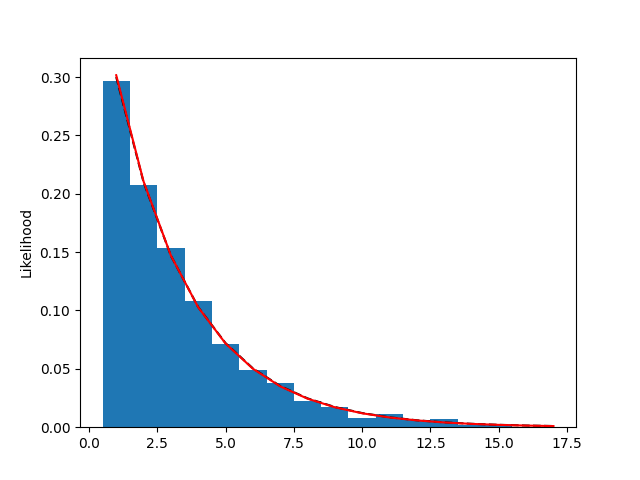

In [12]:
fig, ax = plt.subplots()

omodel = GeometricDistribution(0.3)
data = omodel.sampler(seed=1).sample(1000)
emodel = estimate(data, GeometricEstimator())

xvals = np.arange(np.min(data), np.max(data)+1)

ax.hist(data, bins=xvals-0.5, density=True)
ax.plot(xvals, [omodel.density(u) for u in xvals], '--k', label='Real Model')
ax.plot(xvals, [emodel.density(u) for u in xvals], 'r', label='Estimated Model')
ax.set_ylabel('Likelihood');
fig.show()

### Binomial Distribution (Type: int, Support: $\mathbb{Z}$)

The **Binomial distribution** counts the number of successes in $n$ independent Bernoulli trials with probability of success $p$.

Probability mass function:
$$
P(x|n, p) =
    \begin{cases}
        {n \choose x}(1-p)^{n-x} p^{x}, & x = 0, 1, 2, \dots, n \\
        0, & \text{else}
    \end{cases}
$$

- **Distribution:** `BinomialDistribution(n, p, min_val=0)`
- **Estimator:** `BinomialEstimator()`


In [22]:
fig, ax = plt.subplots()

omodel = BinomialDistribution(n=10, p=0.5, min_val=0)
data = omodel.sampler(seed=1).sample(1000)
emodel = estimate(data, BinomialEstimator())

xvals = np.arange(np.min(data), np.max(data)+1)

ax.hist(data, bins=xvals-0.5, density=True)
ax.plot(xvals, [omodel.density(u) for u in xvals], '--k', label='Real Model')
ax.plot(xvals, [emodel.density(u) for u in xvals], 'r', label='Estimated Model')
ax.set_ylabel('Likelihood');
fig.show()

<IPython.core.display.Javascript object>

The `BinomialDistribution` can also handle negative values. This can be seen by changing the `min_val` parameter of the `BinomialDistribution` object. The `BinomialEstimator` automatically handles a negative support when estimating from data. 

Below we generate 1000 samples from a `BinomialDistribution` with a `min_val=-5`. Notice that the range of values in the histogram now ranges from -5 to 4 (n=10). This allows users to model negative integer valued data. 


In [23]:
fig, ax = plt.subplots()

omodel = BinomialDistribution(n=10, p=0.5, min_val=-5)
data = omodel.sampler(seed=1).sample(1000)
emodel = estimate(data, BinomialEstimator())

xvals = np.arange(np.min(data), np.max(data)+1)

ax.hist(data, bins=xvals-0.5, density=True)
ax.plot(xvals, [omodel.density(u) for u in xvals], '--k', label='Real Model')
ax.plot(xvals, [emodel.density(u) for u in xvals], 'r', label='Estimated Model')
ax.set_ylabel('Likelihood');
fig.show()

<IPython.core.display.Javascript object>

### Categorical Distribution (Type: Union[str, object, int], Support: Any)

The **Categorical distribution** is defined over a set of values $\mathbb{V} = \{v_1, v_2, \dots, v_K\}$, with probabilities $p_k$ summing to 1.

Probability mass function:
$$
P(X = v_k) =
    \begin{cases}
        p_k, & v_k \in \mathbb{V} \\
        0, & \text{else}
    \end{cases}
$$

- **Distribution:** `CategoricalDistribution(pmap)`
- **Estimator:** `CategoricalEstimator()`


In [24]:
pmap = {'a':0.2, 'b': 0.3, 'c': 0.4, 'd': 0.1}

omodel = CategoricalDistribution(pmap=pmap)
data = omodel.sampler(seed=1).sample(1000)
emodel = estimate(data, CategoricalEstimator())

for k, v in sorted(pmap.items(), key=lambda u: u[0]):
    print('Value %s: True prob = %.3f, Estimated prob = %.3f' % (repr(k), v, emodel.pmap[k]))

Value 'a': True prob = 0.200, Estimated prob = 0.203
Value 'b': True prob = 0.300, Estimated prob = 0.291
Value 'c': True prob = 0.400, Estimated prob = 0.404
Value 'd': True prob = 0.100, Estimated prob = 0.102


### Categorical Multinomial Distribution (Type: Sequence[Tuple[str, int]], Support: Any)
The **Categorical Multinomial distribution** models value-counted data, i.e., sequences of $(\text{value}, \text{count})$ pairs.

Probability mass function:
$$
P(\boldsymbol{X} | N) =
    \begin{cases}
        N!\prod_{k=1}^{K}\frac{p_k^{n_k}}{n_k!}, & k=1,2, \dots, K \\
        0, & \text{else}
    \end{cases}
$$

- **Distribution:** `MultinomialDistribution(dist, Optional[len_dist])`
- **Estimator:** `MultinomialEstimator(estimator, Optional[len_estimator])`

The `MultinomialDistribution` allows for user specification of a distribution over the number of trials in the multinomial (`len_dist`). If specified, the joint liklihood becomes, 
$$P(\boldsymbol{X}, N) = P(\boldsymbol{X}| N)P(N).$$

If unspecfied, it is assumed that $P(N)=1$ for every value of $N$.

**Estimation Process**

1. `dist`: Define `MultinomialDistribution` over $\mathbb{V}=\{a, b, c, d\}$ with length distribution `PoissonDistribution(lam=3.0)`. 
2. `data`: Generate 1000 samples from `dist`. 
3. `init`: Initialize the estimate for with initial estimator `iest` using 10% of the data by setting `p=0.10` in `intialize`. 
4. `emodel`: Estimate `MultinomialDistribution` using estimator `est` and initial estimate `init`. 



In [25]:
val_dist = CategoricalDistribution(pmap = {'a':0.2, 'b': 0.3, 'c': 0.4, 'd': 0.1})
len_dist = PoissonDistribution(lam=3.0)
dist = MultinomialDistribution(dist=val_dist, len_dist=len_dist) 

data = dist.sampler(seed=1).sample(1000)
iest = MultinomialEstimator(estimator=CategoricalEstimator(), len_estimator=PoissonEstimator())
rng = np.random.RandomState(1)
print('Samples:')
print('\n'.join(map(str, data[:5])))

print('\nInitialize:')
init = initialize(data, iest, rng, p=0.10)
print(str(init))

est = MultinomialEstimator(estimator=CategoricalEstimator(), len_estimator=PoissonEstimator())
print('\nEstimate:')
emodel = estimate(data, est, init)
print(str(emodel))

Samples:
[('b', 1)]
[('c', 1), ('d', 1)]
[('b', 1), ('c', 1)]
[('a', 1), ('c', 1), ('b', 2)]
[('c', 1), ('d', 2), ('a', 1)]

Initialize:
MultinomialDistribution(CategoricalDistribution({'a': 0.1942675159235669, 'b': 0.2961783439490446, 'c': 0.40445859872611467, 'd': 0.10509554140127389}, default_value=0.0, name=None, keys=None), len_dist=PoissonDistribution(2.9622641509433962, name=None, keys=None), len_normalized=False, name=None, keys=None)

Estimate:
MultinomialDistribution(CategoricalDistribution({'a': 0.18529707955689828, 'b': 0.30379321920107416, 'c': 0.4061765693185633, 'd': 0.10473313192346426}, default_value=0.0, name=None, keys=None), len_dist=PoissonDistribution(2.979, name=None, keys=None), len_normalized=False, name=None, keys=None)


### IntegerCategorical Distribution (Type: int, Support: $\mathbb{Z}$)

The **IntegerCategorical distribution** is a categorical distribution over integer values, often used for efficiency.

Probability mass function:
$$
P(X = k) =
    \begin{cases}
        p_k, & k \in \{0, 1, \dots, K-1\} \\
        0, & \text{else}
    \end{cases}
$$

- **Distribution:** `IntegerCategoricalDistribution(min_val, p_vec)`
- **Estimator:** `IntegerCategoricalEstimator()`

Below, we enumerate the unique observed values and create a dictionary mapping the integer values to $\mathbb{V}$, a mapping from $\mathbb{V}$ to the integers, and convert the data from strings to integers. 


In [26]:
def word_to_int(x: List[str]) -> Tuple[Dict[int, str], Dict[str, int], List[int]]:
    """Function that takes a list of strings and creates a mapping to integer values.
    
    Args:
        x (List[str]): String values
    
    Returns:
        maps from words to ints and inverse mapping
        
    """
    
    int_map = {}
    rv = []
    cnt = 0 
    for xx in x:

        if xx not in int_map:
            int_map[xx] = cnt 
            rv.append(cnt)
            cnt += 1 
        else:
            rv.append(int_map[xx])
            
    return int_map, {v:k for k,v in int_map.items()}, rv 

The inference remains unchanged as seen below. 

In [27]:
pmap = {'a':0.2, 'b': 0.3, 'c': 0.4, 'd': 0.1}

omodel = CategoricalDistribution(pmap=pmap)
data = omodel.sampler(seed=1).sample(1000)

In [28]:
int_map, inv_int_map, rv = word_to_int(data)
emodel = estimate(rv, IntegerCategoricalEstimator())

for k, v in sorted(pmap.items(), key=lambda u: u[0]):
    print('Value %s: Integer value %s, True prob = %.3f, Estimated prob = %.3f' % (repr(k), repr(int_map[k]), v, emodel.p_vec[int_map[k]]))

Value 'a': Integer value 2, True prob = 0.200, Estimated prob = 0.203
Value 'b': Integer value 0, True prob = 0.300, Estimated prob = 0.291
Value 'c': Integer value 1, True prob = 0.400, Estimated prob = 0.404
Value 'd': Integer value 3, True prob = 0.100, Estimated prob = 0.102


The integer categorical can also be used to estimate the probability of observing an integer value over a range of observed integer values. Below we generate integers on the range of $[-10, -1]$, and estimate the probability of observing each integer value. 

In [29]:
fig, ax = plt.subplots()

p_vec = np.random.RandomState(1).dirichlet(np.ones(10))
omodel = IntegerCategoricalDistribution(min_val=-10, p_vec=p_vec)
data = omodel.sampler(seed=1).sample(1000)

xvals = np.arange(np.min(data), np.max(data)+1)

ax.hist(data, bins=xvals-0.5, density=True)
ax.set_ylabel('Likelihood');
fig.show()

<IPython.core.display.Javascript object>

In [30]:
emodel = estimate(data, IntegerCategoricalEstimator())
p0 = np.round(p_vec,2)
p1 = np.round(emodel.p_vec,2)

for i in range(len(emodel.p_vec)):
    print('Value: %i, True Prob = %.2f, Predicted Prob = %.2f' % (emodel.min_val+i, p0[i], p1[i]))

Value: -10, True Prob = 0.12, Predicted Prob = 0.12
Value: -9, True Prob = 0.29, Predicted Prob = 0.29
Value: -8, True Prob = 0.00, Predicted Prob = 0.00
Value: -7, True Prob = 0.08, Predicted Prob = 0.08
Value: -6, True Prob = 0.04, Predicted Prob = 0.04
Value: -5, True Prob = 0.02, Predicted Prob = 0.03
Value: -4, True Prob = 0.05, Predicted Prob = 0.05
Value: -3, True Prob = 0.10, Predicted Prob = 0.10
Value: -2, True Prob = 0.12, Predicted Prob = 0.12
Value: -1, True Prob = 0.18, Predicted Prob = 0.17


### Bernoulli Set Distribution (Type: Sequence[str], Support: Any)

The **Bernoulli set distribution** models observations of subsets of a finite set $\mathbb{V}$. Each element is included independently with probability $p_k$.

Probability:
$$
P(\mathbf{x}) = \prod_{k = 1}^K p_k^{s_k}(1-p_k)^{1-s_k}
$$
where $s_k = 1$ if $v_k \in \mathbf{x}$, $0$ otherwise.

- **Distribution:** `BernoulliSetDistribution(pmap)`
- **Estimator:** `BernoulliSetEstimator()`

In [33]:
data = BernoulliSetDistribution({'cat': 0.90, 'dog': 0.30, 'turtle': 0.60}).sampler(seed=1).sample(1000)
omodel = BernoulliSetDistribution(pmap={'cat': 0.9, 'dog': 0.3, 'turtle': 0.6})
data = omodel.sampler(seed=1).sample(1000)
emodel = estimate(data, BernoulliSetEstimator())

print('Sample data:')
print('\n'.join([str(data[i]) for i in range(10)]))
print('\nTruth:')
print(', '.join([ '%s: %.2f' % (k, np.round(v,2)) for k, v in sorted(omodel.pmap.items(), key= lambda u: u[0])]))
print('\nEstimate:')
print(', '.join([ '%s: %.2f' % (k, np.round(v,2)) for k, v in sorted(emodel.pmap.items(), key= lambda u: u[0])]))

Sample data:
['cat', 'turtle']
['cat']
['cat']
['cat', 'turtle']
['cat', 'turtle']
['cat', 'dog', 'turtle']
['cat', 'dog']
['cat', 'turtle']
['cat', 'dog', 'turtle']
['cat', 'turtle']

Truth:
cat: 0.90, dog: 0.30, turtle: 0.60

Estimate:
cat: 0.90, dog: 0.29, turtle: 0.63


### Integer Bernoulli Set Distribution (Type: Sequence[int], Support: $\mathbb{Z}$)

The **Integer Bernoulli Set distribution** is the integer-mapped version of the Bernoulli set distribution.

- **Distribution:** `IntegerBernoulliSetDistribution(num_vals, log_pvec)`
- **Estimator:** `IntegerBernoulliSetEstimator(num_vals)`

In general, it is computationally advatageous to map the elements to integers and use `IntegerBernoulliSetEstimator` for estimation.

In [34]:
def str_set_to_ints(str_set_data: List[List[str]]) -> tuple[dict, dict, list]:
    """Maps words of set to integers.
    
    str_set_data (List[List[str]]): Observations of word sets.

    Returns:
        mapping from elements to integers, inverse mapping, mapped dataset

    """
    int_map = {}
    cnt = 0
    rv = []
    for xx in str_set_data:
        temp = []
        for w in xx:
            if w not in int_map:
                int_map[w] = cnt 
                cnt += 1 
            temp.append(int_map[w])
        rv.append(temp)
        
    return int_map, {v:k for k, v in int_map.items()}, rv

int_map, inv_int_map, int_data = str_set_to_ints(data)
imodel = estimate(int_data, IntegerBernoulliSetEstimator(num_vals=len(int_map)))
print('Mapping: ' + ', '.join(['%i: %s' % (v, repr(k)) for k, v in int_map.items()]))
s = 'IntegerBernoulliSetDistribution: '
s += ', '.join(['%i (%s): %.2f' % (v, repr(k), np.round(np.exp(imodel.log_pvec[v]),2))for k,v in sorted(int_map.items(), key=lambda u: u[0])])
print(s)

Mapping: 0: 'cat', 1: 'turtle', 2: 'dog'
IntegerBernoulliSetDistribution: 0 ('cat'): 0.90, 2 ('dog'): 0.29, 1 ('turtle'): 0.63


### Spike and Slab Distribution (Type: int, Support: [a, b])

The **Spike and Slab distribution** defines a distribution on integers $[a, b]$ with a spike at $k$.

Probability mass function:
$$
P(X=x) =
    \begin{cases}
        p, & x = k \\
        \frac{1-p}{b-a}, & x \in [a,b]\setminus{\{k\}} \\
        0, & \text{else}
    \end{cases}
$$

- **Distribution:** `IntegerUniformSpikeDistribution(k, p, min_val, num_vals)`
- **Estimator:** `IntegerUniformSpikeEstimator()`


In [35]:
fig, ax = plt.subplots()

omodel = SpikeAndSlabDistribution(k=3, p=0.4, min_val=0, num_vals=10)
data = omodel.sampler(seed=1).sample(1000)
emodel = estimate(data, SpikeAndSlabEstimator())

xvals = np.arange(np.min(data), np.max(data)+1)
ax.hist(data, bins=xvals-0.5, density=True)
ax.set_ylabel('Likelihood');
fig.show()

<IPython.core.display.Javascript object>

In [36]:
print('True p=%.3f, True k=%i\n' % (omodel.p, omodel.k))
print('Estimated p = %.3f, Estimated k=%i' %(emodel.p, emodel.k))

True p=0.400, True k=3

Estimated p = 0.399, Estimated k=3


### Markov Chain (Type: str, Support: Any)

A **Markov chain** models sequences of events where the outcome of each event depends only on the previous state. In other words, a sequence of random variables $X_1, X_2, X_3, \dots$ has the Markov property if:

$$
P\left(X_{n} \mid X_1, X_2, \dots, X_{n-1}\right) = P\left(X_{n} \mid X_{n-1}\right)
$$

The `MarkovChainDistribution` object defines a Markov chain for a set of values $\mathbb{V} = \{v_1, v_2, \dots, v_K\}$ using:
- An **initial probability distribution**: $\pi_k = P(X_1 = v_k)$
- A **transition probability matrix**: $P(X_{n} = v_j \mid X_{n-1} = v_i)$

**Notes:**
- The transition probabilities dictionary `trans_map` maps each state $v_k$ to a dictionary of transition probabilities to other states.
- The initial probability dictionary `init_prob` specifies the starting probabilities for each state.
- `len_dist` specifies a distribution for the sequence lengths.
- Initialization for estimation can be done by randomly selecting a subset of observed sequences.

**Example:**
- $\mathbb{V} = \{\text{'a'}, \text{'b'}, \text{'c'}\}$
- `trans_map` and `init_prob` are dictionaries with probabilities summing to 1.0.
- `len_dist` is a categorical distribution over possible sequence lengths.



In [37]:
init_prob = {'a': 0.4, 'b': 0.4, 'c':0.2}
trans_map = {'a': {'a': 0.8, 'b': 0.2}, 'b': {'b': 0.8, 'c': 0.2}, 'c': {'a': 0.5, 'b': 0.5}}
len_dist = CategoricalDistribution({3:0.5, 8:0.5})
dist = MarkovChainDistribution(init_prob, trans_map, len_dist=len_dist)

data = dist.sampler(seed=1).sample(1000)
est = MarkovChainEstimator(len_estimator=CategoricalEstimator())
rng = np.random.RandomState(1)
print('Samples:')
print('\n'.join(map(str, data[:5])))

print('\nInitialize:')
init = initialize(data, est, rng, p=0.10)
print(str(init))

print('\nEstimate:')
print(str(estimate(data, MarkovChainEstimator(len_estimator=CategoricalEstimator()), init)))

Samples:
['c', 'b', 'b']
['c', 'a', 'a', 'a', 'a', 'b', 'c', 'a']
['b', 'b', 'b', 'b', 'c', 'a', 'a', 'b']
['b', 'b', 'c']
['a', 'a', 'b', 'c', 'b', 'b', 'b', 'b']

Initialize:
MarkovChainDistribution({'a': 0.4339622641509434, 'b': 0.4528301886792453, 'c': 0.11320754716981132}, {'a': {'a': 0.7603305785123967, 'b': 0.2396694214876033}, 'b': {'b': 0.8207547169811321, 'c': 0.1792452830188679}, 'c': {'a': 0.5131578947368421, 'b': 0.4868421052631579}}, len_dist=CategoricalDistribution({3: 0.0, 8: 1.0}, default_value=0.0, name=None, keys=None), default_value=0.0, name=None, keys=None)

Estimate:
MarkovChainDistribution({'a': 0.39, 'b': 0.426, 'c': 0.184}, {'a': {'a': 0.8012895662368112, 'b': 0.19871043376318875}, 'b': {'b': 0.7917026793431288, 'c': 0.20829732065687123}, 'c': {'a': 0.5, 'b': 0.5}}, len_dist=CategoricalDistribution({3: 0.486, 8: 0.514}, default_value=0.0, name=None, keys=None), default_value=0.0, name=None, keys=None)


## Combinators

Now that we have covered several of the **base distributions** for continuous and discrete data types, we can look at the real power of PySparkPlug: **combinators**. Combinators are distributions that wrap base distributions to jointly model the generative process of data. They allow you to construct models for a wide array of heterogeneous data types.


### Composite (Type: Tuple[Any, ...], Support: Any)

The `CompositeDistribution` combines multiple independent random variables to produce a joint probability distribution. The corresponding estimator is `CompositeEstimator`, which takes a list of estimators.

**Example:**  
A composite model over two independent Gaussians is show below.


In [38]:
fig = plt.figure()
ax  = fig.add_subplot(111)

dist1 = GaussianDistribution(1.0, 2.0)
dist2 = GaussianDistribution(3.0, 8.0)
dist = CompositeDistribution((dist1, dist2))
data = dist.sampler(seed=1).sample(1000)

rng = np.random.RandomState(1)
est = CompositeEstimator([GaussianEstimator()]*2)
init = initialize(data, est, rng, p=.10)

print(str(estimate(data, est, init)))

data = np.asarray(data)
ax.hist2d(data[:, 0], data[:, 1], bins=20);
fig.show()

<IPython.core.display.Javascript object>

CompositeDistribution(dists=[GaussianDistribution(1.0361188291060448, 2.008579014252616, name=None, keys=None),GaussianDistribution(3.0116733145368224, 7.911263125756927, name=None, keys=None)], name=None, keys=None)


The above example is not super exciting, as a joint Gaussian already contains the same two data types (floats). Lets take a look at a `CompositeDistribution` defined over data that looks like 
$$obs = (counts, letters, integer).$$

We can model the observed data above compoennt-wise with a `PoissonDistribution`, `CategoricalDistribution`, and a `GaussianDistribution`. The estimator is defined by specifying individual estimators for each data type of the tuple. 

In [39]:
dist1 = PoissonDistribution(lam=3.0)
dist2 = CategoricalDistribution(pmap={'a':0.3, 'b':0.7})
dist3 = GaussianDistribution(1.0, 2.0)

dist = CompositeDistribution((dist1, dist2, dist3))
data = dist.sampler(seed=1).sample(1000)

rng = np.random.RandomState(1)
est0 = PoissonEstimator()
est1 = CategoricalEstimator()
est2 = GaussianEstimator()
est = CompositeEstimator([est0, est1, est2])
init = initialize(data, est, rng, p=.10)

print('Model:')
print(str(dist))
print('\nSamples:')
print('\n'.join(map(str, data[:5])))
print('\nEstimate:')
print(str(estimate(data, est, init)))

Model:
CompositeDistribution(dists=[PoissonDistribution(3.0, name=None, keys=None),CategoricalDistribution({'a': 0.3, 'b': 0.7}, default_value=0.0, name=None, keys=None),GaussianDistribution(1.0, 2.0, name=None, keys=None)], name=None, keys=None)

Samples:
(4, 'b', np.float64(-0.5896057427239183))
(2, 'a', np.float64(2.7641808189968593))
(3, 'b', np.float64(0.9122118807402247))
(2, 'a', np.float64(0.36662169023795355))
(2, 'b', np.float64(3.1004083206816464))

Estimate:
CompositeDistribution(dists=[PoissonDistribution(3.124, name=None, keys=None),CategoricalDistribution({'a': 0.317, 'b': 0.683}, default_value=0.0, name=None, keys=None),GaussianDistribution(1.0040014353384765, 1.9909410034521706, name=None, keys=None)], name=None, keys=None)


### Sequence

The `SequenceDistribution` and `SequenceEstimator` are used for modeling data observed as independent and identically distributed sequences. You specify a base distribution or estimator for the sequence elements, and optionally a distribution/estimator for the sequence length.

**Example:**

In [40]:
dist = CategoricalDistribution({'cat': 0.1, 'dog': 0.3, 'turtle': 0.6})
len_dist = CategoricalDistribution({1: 0.3, 2: 0.5, 3:0.2})
data = SequenceDistribution(dist, len_dist=len_dist).sampler(seed=1).sample(1000)
est0 = CategoricalEstimator()
est = SequenceEstimator(est0, len_estimator=est0)
rng = np.random.RandomState(1) 

print('Initialize:')
init = initialize(data, est, rng, p=0.10)
print(str(init))
print('\nEstimate:')
print(str(estimate(data, est, init)))
print('\nSamples:')
print('\n'.join([str(data[i]) for i in range(10)]))

Initialize:
SequenceDistribution(CategoricalDistribution({'cat': 0.07920792079207921, 'dog': 0.2722772277227723, 'turtle': 0.6485148514851485}, default_value=0.0, name=None, keys=None), len_dist=CategoricalDistribution({1: 0.29245283018867924, 2: 0.5094339622641509, 3: 0.19811320754716982}, default_value=0.0, name=None, keys=None), len_normalized=False, name=None, keys=None)

Estimate:
SequenceDistribution(CategoricalDistribution({'cat': 0.09572192513368984, 'dog': 0.2914438502673797, 'turtle': 0.6128342245989304}, default_value=0.0, name=None, keys=None), len_dist=CategoricalDistribution({1: 0.317, 2: 0.496, 3: 0.187}, default_value=0.0, name=None, keys=None), len_normalized=False, name=None, keys=None)

Samples:
['dog', 'turtle']
['turtle']
['dog', 'turtle']
['cat']
['turtle', 'dog']
['turtle', 'turtle', 'turtle']
['cat']
['turtle']
['turtle', 'cat']
['turtle', 'dog']


### Conditional

The `ConditionalDistribution` computes conditional probability density $P(Y|X)$ when the data format is a tuple `(X, Y)`.  
- If `given_estimator` is specified, `ConditionalDistributionEstimator` will estimate the joint probability $P(Y|X)P(X)$.
- If `given_dist` is specified, `ConditionalDistribution` will compute the joint probability $P(Y|X)P(X)$.

**Example:**

In [41]:
dist1 = GaussianDistribution(1.0, 2.0)
dist2 = GeometricDistribution(0.2)
dist3 = CategoricalDistribution({'a': 0.6, 'b': 0.4})
dist = ConditionalDistribution({'a': dist1, 'b': dist2}, given_dist=dist3)
data = dist.sampler(seed=1).sample(1000)

print('Estimate:')
est0 = GaussianEstimator()
est1 = GeometricEstimator()
given_est = CategoricalEstimator()
est = ConditionalDistributionEstimator({'a': est0, 'b': est1}, given_estimator=given_est)
rng = np.random.RandomState(1)
init = initialize(data, est, rng, p=0.10)
print(str(estimate(data, est, init)))
print('\nSamples:')
print('\n'.join(map(str, data[:5])))

Estimate:
ConditionalDistribution({'a': GaussianDistribution(1.0152882528804092, 2.0892464476947583, name=None, keys=None), 'b': GeometricDistribution(0.21301775147928995, name=None, keys=None)}, default_dist=NullDistribution(name=None), given_dist=CategoricalDistribution({'a': 0.604, 'b': 0.396}, default_value=0.0, name=None, keys=None), name=None, keys=None)

Samples:
('b', 8)
('a', -0.5896057427239183)
('a', 2.7641808189968593)
('a', 0.9122118807402247)
('a', 0.36662169023795355)


### Ignored Distribution

The `IgnoredDistribution` and `IgnoredEstimator` classes provide a way to ignore particular features or specify distributions that are known in advance.

**Example:**  
Estimate only the first component of a composite, keeping the second fixed:




In [43]:
fig = plt.figure()
ax  = fig.add_subplot(111)

dist1 = GaussianDistribution(1.0, 2.0)
dist2 = GaussianDistribution(3.0, 8.0)
dist = CompositeDistribution((dist1, IgnoredDistribution(dist2)))
data = dist.sampler(seed=1).sample(1000)

est0 = GaussianEstimator()
est1 = IgnoredEstimator(dist2)
est = CompositeEstimator([est0, est1])
rng = np.random.RandomState(1)
init = initialize(data, est, rng, p=0.10)

print(str(estimate(data, est, init)))

data = np.asarray(data)
ax.hist2d(data[:, 0], data[:, 1], bins=20);
fig.show()

<IPython.core.display.Javascript object>

CompositeDistribution(dists=[GaussianDistribution(1.0361188291060448, 2.008579014252616, name=None, keys=None),IgnoredDistribution(GaussianDistribution(3.0, 8.0, name=None, keys=None), name=None, keys=None)], name=None, keys=None)


### Optional

The `OptionalDistribution` allows for potentially missing data. You specify the probability `p` of being missing and a `missing_value`.

**Example:**  
Composite with an optional second component:

In [44]:
dist1 = GaussianDistribution(1.0, 2.0)
dist2 = GaussianDistribution(3.0, 8.0)
dist = CompositeDistribution((dist1, OptionalDistribution(dist2, p=0.3, missing_value=None)))
data = dist.sampler(seed=1).sample(1000)

est0 = GaussianEstimator()
est1 = OptionalEstimator(GaussianEstimator(), est_prob=True, missing_value=None)
est = CompositeEstimator([est0, est1])
rng = np.random.RandomState(1)
init = initialize(data, est, rng, p=0.10)
print('Samples:')
print(', '.join(['(%0.5f, %0.5f)'%(xx[0], xx[1]) if xx[1] is not None else '(%0.5f, None)' % (xx[0]) for xx in data[:10]]))
print('\nEstimate:')
print(str(estimate(data, est, init)))

Samples:
(2.08125, 2.19888), (-0.58999, -2.10789), (0.80581, 4.56132), (1.74691, -1.93245), (-0.18494, 1.68720), (1.22639, None), (0.04978, None), (2.00850, -3.42771), (2.84966, 5.53328), (0.89192, 5.04673)

Estimate:
CompositeDistribution(dists=[GaussianDistribution(1.0361188291060448, 2.008579014252616, name=None, keys=None),OptionalDistribution(GaussianDistribution(2.897081185513912, 7.703231587973823, name=None, keys=None), p=0.299, missing_value=None, name=None, keys=None)], name=None, keys=None)
